In [ ]:
!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [78]:
#@title Get metars and meteorological model
import os
import sys
import numpy as np
import pandas as pd
from datetime import timedelta
from io import BytesIO
import base64
import pickle
import warnings

warnings.filterwarnings("ignore")

# to get the help functions add at path system
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LEVX_1km')
#import help_functions

def get_metar(oaci,control):
     """
     get metar from IOWA university database
     
     in: OACI airport code
     Returns
      -------
     dataframe with raw metar.
     """
     #today metar control =True
     if control:
       today = pd.to_datetime("today")+timedelta(1)
       yes = today-timedelta(1)
     else:
        today = pd.to_datetime("today")+timedelta(1)
        yes = today-timedelta(2)

     #url string
     s1="https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station="
     s2="&data=all"
     s3="&year1="+yes.strftime("%Y")+"&month1="+yes.strftime("%m")+"&day1="+yes.strftime("%d")
     s4="&year2="+today.strftime("%Y")+"&month2="+today.strftime("%m")+"&day2="+today.strftime("%d")
     s5="&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2"
     url=s1+oaci+s2+s3+s4+s5
     df_metar_global=pd.read_csv(url,parse_dates=["valid"],).rename({"valid":"time"},axis=1)
     df_metar = df_metar_global[["time",'tmpf', 'dwpf','drct', 'sknt', 'alti','vsby',
                                 'gust', 'skyc1', 'skyc2', 'skyl1', 'skyl2','wxcodes',
                                 "metar"]].set_index("time")
     
     #temperature dry a dew point to celsius                            
     df_metar["temp_o"] = np.rint((df_metar.tmpf - 32)*5/9)
     df_metar["tempd_o"] = np.rint((df_metar.dwpf - 32)*5/9)

     #QNH to mb
     df_metar["mslp_o"] = np.rint(df_metar.alti*33.8638)

     #visibility SM to meters
     df_metar["visibility_o"] =np.rint(df_metar.vsby/0.00062137)

     #wind direction, intensity and gust
     df_metar["spd_o"] = df_metar["sknt"]
     df_metar["dir_o"] = df_metar["drct"]
     df_metar['gust_o'] = df_metar['gust'] 

     #Add suffix cloud cover and cloud height, present weather, and metar 
     df_metar['skyc1_o'] = df_metar['skyc1']
     df_metar["skyl1_o"] = df_metar["skyl1"]
     df_metar['skyc2_o'] = df_metar['skyc2']
     df_metar["skyl2_o"] = df_metar["skyl2"]
     df_metar["wxcodes_o"] = df_metar["wxcodes"]
     df_metar["metar_o"] = df_metar["metar"]
     

     # Select all columns that do not start with "_o"
     columns_to_keep = [col for col in df_metar.columns if col.endswith("_o")]
     df_metar = df_metar[columns_to_keep] 

     return df_metar 



  
def get_meteogalicia_model_1Km(coorde):
    """
    get meteogalicia model (1Km)from algo coordenates
    Returns
    -------
    dataframe with meteeorological variables forecasted.
    """
    
    #defining url to get model from Meteogalicia server
    #today = C
    #today = pd.to_datetime("today")+timedelta(1)
    today = pd.to_datetime("today")

    try:

      head1 = "http://mandeo.meteogalicia.es/thredds/ncss/wrf_1km_baixas/fmrc/files/"
      head2 = today.strftime("/%Y%m%d/wrf_arw_det1km_history_d05")
      head3 = today.strftime("_%Y%m%d_0000.nc4?")
      head = head1+head2+head3
  
      var1="var=dir&var=mod&var=wind_gust&var=mslp&var=temp&var=rh&var=visibility&var=lhflx"
      var2="&var=lwflx&var=conv_prec&var=prec&var=swflx&var=shflx&var=cape&var=cin&var=cfh&var=T850"
      var3="&var=cfl&var=cfm&var=cft&var=HGT500&var=HGT850&var=T500&var=snow_prec&var=snowlevel"
      var=var1+var2+var3
  
      f_day=(today+timedelta(days=2)).strftime("%Y-%m-%d") 
      tail="&time_start="+today.strftime("%Y-%m-%d")+"T01%3A00%3A00Z&time_end="+f_day+"T23%3A00%3A00Z&accept=csv"
  
      dffinal=pd.DataFrame() 
      for coor in list(zip(coorde.lat.tolist(),coorde.lon.tolist(),np.arange(0,len(coorde.lat.tolist())).astype(str))):
          dffinal=pd.concat([dffinal,pd.read_csv(head+var+"&latitude="+str(coor[0])+"&longitude="+str(coor[1])+tail,).add_suffix(str(coor[2]))],axis=1)    
  
      
      #filter all columns with lat lon and date
      dffinal=dffinal.filter(regex='^(?!(lat|lon|date).*?)')
  
      #remove column string between brakets
      new_col=[c.split("[")[0]+c.split("]")[-1] for c in dffinal.columns]
      for col in zip(dffinal.columns,new_col):
          dffinal=dffinal.rename(columns = {col[0]:col[1]})
  
      dffinal=dffinal.set_index(pd.date_range(start=today.strftime("%Y-%m-%d"), end=(today+timedelta(days=3)).strftime("%Y-%m-%d"), freq="H")[1:-1])  
      control = True
    except:

      today = pd.to_datetime("today")-timedelta(1)
      head1 = "http://mandeo.meteogalicia.es/thredds/ncss/wrf_1km_baixas/fmrc/files/"
      head2 = today.strftime("/%Y%m%d/wrf_arw_det1km_history_d05")
      head3 = today.strftime("_%Y%m%d_0000.nc4?")
      head = head1+head2+head3
  
      var1="var=dir&var=mod&var=wind_gust&var=mslp&var=temp&var=rh&var=visibility&var=lhflx"
      var2="&var=lwflx&var=conv_prec&var=prec&var=swflx&var=shflx&var=cape&var=cin&var=cfh&var=T850"
      var3="&var=cfl&var=cfm&var=cft&var=HGT500&var=HGT850&var=T500&var=snow_prec&var=snowlevel"
      var=var1+var2+var3
  
      f_day=(today+timedelta(days=2)).strftime("%Y-%m-%d") 
      tail="&time_start="+today.strftime("%Y-%m-%d")+"T01%3A00%3A00Z&time_end="+f_day+"T23%3A00%3A00Z&accept=csv"
  
      dffinal=pd.DataFrame() 
      for coor in list(zip(coorde.lat.tolist(),coorde.lon.tolist(),np.arange(0,len(coorde.lat.tolist())).astype(str))):
          dffinal=pd.concat([dffinal,pd.read_csv(head+var+"&latitude="+str(coor[0])+"&longitude="+str(coor[1])+tail,).add_suffix(str(coor[2]))],axis=1)    
  
      
      #filter all columns with lat lon and date
      dffinal=dffinal.filter(regex='^(?!(lat|lon|date).*?)')
  
      #remove column string between brakets
      new_col=[c.split("[")[0]+c.split("]")[-1] for c in dffinal.columns]
      for col in zip(dffinal.columns,new_col):
          dffinal=dffinal.rename(columns = {col[0]:col[1]})
  
      dffinal=dffinal.set_index(pd.date_range(start=today.strftime("%Y-%m-%d"), end=(today+timedelta(days=3)).strftime("%Y-%m-%d"), freq="H")[1:-1])  
      control= False  

     
    return dffinal , control


# Set the directory you want to list algorithms filenames from
algo_dir = '/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/'

#get meteorological model from algorithm file. Select "coor" key to get coordinates. Pick up first algorithm all same coordinates
meteo_model,con = get_meteogalicia_model_1Km(pickle.load(open(algo_dir+os.listdir(algo_dir)[0],"rb"))["coor"])

#add time variables
meteo_model["hour"] = meteo_model.index.hour
meteo_model["month"] = meteo_model.index.month
meteo_model["dayofyear"] = meteo_model.index.dayofyear
meteo_model["weekofyear"] = meteo_model.index.isocalendar().week.astype(int)

#show meteorological model and control variable. Control variable True if Day analysis = today 
print("Day analysis = today :",con)
meteo_model.info()


metars = get_metar("LEVX",con)
metars

Day analysis = today : True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2022-12-26 01:00:00 to 2022-12-28 23:00:00
Freq: H
Data columns (total 54 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dir0         71 non-null     float64
 1   mod0         71 non-null     float64
 2   wind_gust0   71 non-null     float64
 3   mslp0        71 non-null     float64
 4   temp0        71 non-null     float64
 5   rh0          71 non-null     float64
 6   visibility0  71 non-null     float64
 7   lhflx0       71 non-null     float64
 8   lwflx0       71 non-null     float64
 9   conv_prec0   71 non-null     float64
 10  prec0        71 non-null     float64
 11  swflx0       71 non-null     float64
 12  shflx0       71 non-null     float64
 13  cape0        71 non-null     float64
 14  cin0         71 non-null     float64
 15  cfh0         71 non-null     float64
 16  T8500        71 non-null     float64
 17  cfl0         71 non-

,temp_o,tempd_o,mslp_o,visibility_o,spd_o,dir_o,gust_o,skyc1_o,skyl1_o,skyc2_o,skyl2_o,wxcodes_o,metar_o
time,,,,,,,,,,,,,
2022-12-26 00:00:00,11.0,11.0,1020.0,644.0,5.0,190.00,M,SCT,100.0,BKN,200.00,FG,LEVX 260000Z 19005KT 150V220 0650 R19/P2000N R...
2022-12-26 00:30:00,11.0,11.0,1020.0,6003.0,4.0,190.00,M,SCT,100.0,BKN,200.00,BCFG,LEVX 260030Z 19004KT 150V220 6000 BCFG SCT001 ...
2022-12-26 01:00:00,11.0,11.0,1021.0,901.0,5.0,190.00,M,SCT,0.0,BKN,200.00,BCFG DZ,LEVX 260100Z 19005KT 160V220 0900 R19/1900N R0...
2022-12-26 01:30:00,11.0,11.0,1021.0,145.0,2.0,M,M,BKN,0.0,BKN,200.00,FG DZ,LEVX 260130Z VRB02KT 0150 R19/0400D R01/0150N ...
2022-12-26 02:00:00,11.0,11.0,1021.0,193.0,2.0,M,M,FEW,0.0,BKN,100.00,FG,LEVX 260200Z VRB02KT 0200 R19/0300D R01/0200N ...
2022-12-26 02:30:00,10.0,10.0,1021.0,145.0,0.0,0.00,M,FEW,0.0,BKN,100.00,FG,LEVX 260230Z 00000KT 0150 R19/0175N R01/0225D ...
2022-12-26 03:00:00,10.0,10.0,1022.0,354.0,3.0,240.00,M,FEW,100.0,SCT,1400.00,BCFG,LEVX 260300Z 24003KT 200V270 0350 R19/0650D R0...
2022-12-26 03:30:00,10.0,10.0,1022.0,306.0,2.0,M,M,SCT,100.0,BKN,2500.00,BCFG,LEVX 260330Z VRB02KT 0300 R19/0325N R01/0325N ...
2022-12-26 04:00:00,10.0,10.0,1022.0,354.0,2.0,M,M,BKN,100.0,BKN,200.00,BCFG,LEVX 260400Z VRB02KT 0350 R19/1000U R01/0900N ...


***Wind intensity knots***
Reference (48 hours) Mean absolute error meteorological model: 1.35
Reference (48 hours) Mean absolute error machine learning: 0.89



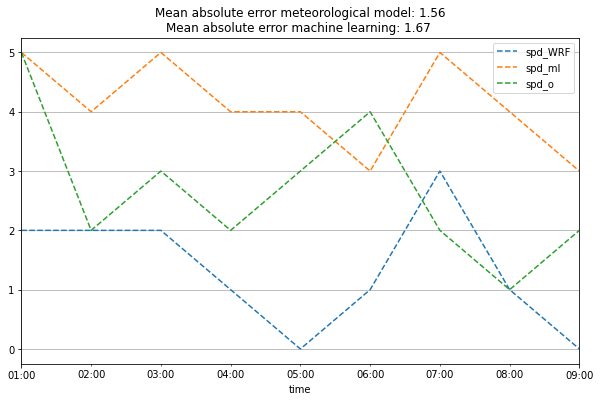

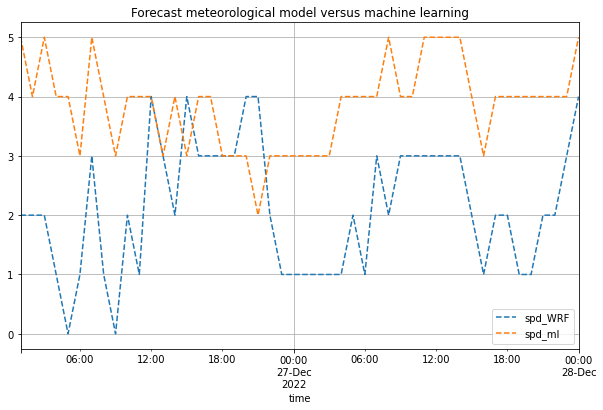

In [79]:
#@title Wind intensity
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#open algorithm spd d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/spd_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/spd_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat spd from ml
spd_ml = alg["pipe"].predict(meteo_model[:24][alg["x_var"]])
spd_ml1 = alg1["pipe"].predict(meteo_model[24:48][alg1["x_var"]])

df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "spd_WRF": np.concatenate((np.rint(model_x_var["mod0"]*1.94384),
                                                   np.rint(model_x_var1["mod0"]*1.94384)),axis=0),
                       "spd_ml": np.concatenate((np.rint(spd_ml*1.94384),
                                                  np.rint(spd_ml1*1.94384)),axis =0),})
df_for = df_for.set_index("time")

#metar versus forecast
# set the max columns to none
pd.set_option('display.max_rows', 100)

# concat metars an forecast
df_res = pd.concat([df_for,metars["spd_o"]],axis = 1)

#get mae
df_res_dropna = df_res.dropna()
mae_ml = round(mean_absolute_error(df_res_dropna.spd_o,df_res_dropna.spd_ml),2)
mae_wrf = round(mean_absolute_error(df_res_dropna.spd_o,df_res_dropna.spd_WRF),2)

#print results
print("***Wind intensity knots***")
print("Reference (48 hours) Mean absolute error meteorological model: 1.35")
print("Reference (48 hours) Mean absolute error machine learning: 0.89\n")

#print("\n",df_res[["spd_ml","spd_o","spd_WRF"]])
title = "Mean absolute error meteorological model: {}\nMean absolute error machine learning: {} ".format(mae_wrf,mae_ml)

#show results
df_res.dropna().plot(grid=True,figsize=(10,6),linestyle='--',title = title);
df_for.plot(grid=True,figsize=(10,6),linestyle='--', title = "Forecast meteorological model versus machine learning");

***Wind direction***
Reference (48 hours) Accuracy meteorological model: 0.20
Reference (48 hours) Accuracy machine learning: 0.41


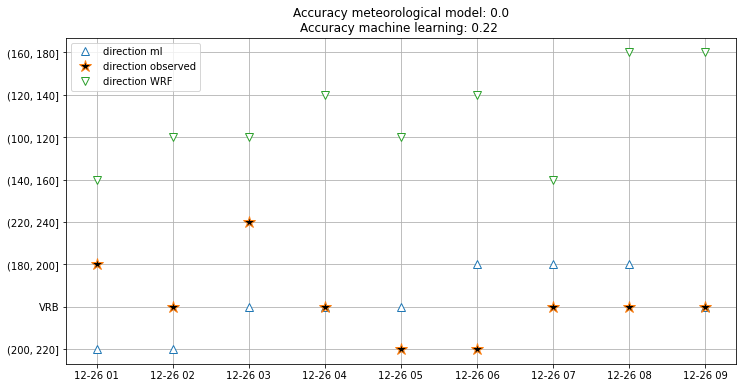

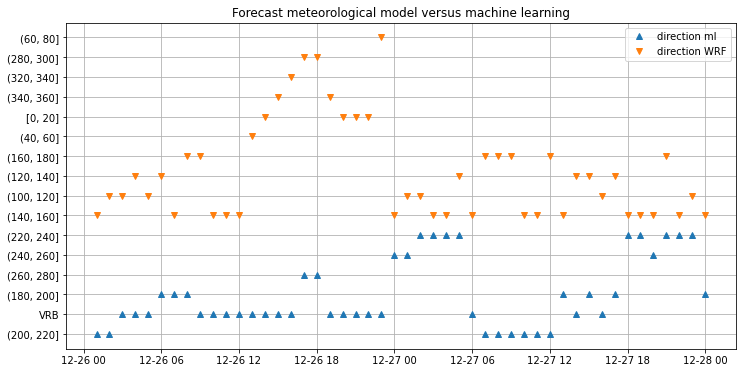

In [80]:
#@title wind direction
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#open algorithm spd d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/dir_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/dir_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat spd from ml
dir_ml = alg["pipe"].predict(model_x_var)
dir_ml1 = alg1["pipe"].predict(model_x_var1)

#set up dataframe forecast machine learning and WRF
df_for = pd.DataFrame({"time":meteo_model[:48].index,
                        "dir_WRF": np.concatenate((model_x_var["dir0"],model_x_var1["dir0"]),axis=0),
                        "dir_ml": np.concatenate((dir_ml,dir_ml1),axis =0),})
df_for = df_for.set_index("time")

#label dir_o and dir0 .wind direction to interval dir=-1 variable wind
interval = pd.IntervalIndex.from_tuples([(-1.5, -0.5),(-0.5,20), (20, 40), (40, 60),
                                           (60,80),(80,100),(100,120),(120,140),(140,160),
                                           (160,180),(180,200),(200,220),(220,240),
                                           (240,260),(260,280),(280,300),(300,320),
                                           (320,340),(340,360)])

labels = ['VRB', '[0, 20]', '(20, 40]', '(40, 60]','(60, 80]', '(80, 100]',
          '(100, 120]', '(120, 140]','(140, 160]', '(160, 180]', '(180, 200]',
          '(200, 220]','(220, 240]', '(240, 260]', '(260, 280]', '(280, 300]',
          '(300, 320]', '(320, 340]', '(340, 360]']

df_for["dir_WRF_l"] = pd.cut(df_for["dir_WRF"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)

#dir_o to intervals 
metars["dir_o_l"] = pd.cut(metars["dir_o"].replace("M",-1).astype(float), bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)                    

#metar versus forecast
# set the max columns to none
pd.set_option('display.max_rows', 100)

# concat metars an forecast
df_res = pd.concat([df_for,metars[["dir_o","dir_o_l"]]],axis = 1)

#get accuracy
df_res_dropna = df_res.dropna()
acc_ml = round(accuracy_score(df_res_dropna.dir_o_l,df_res_dropna.dir_ml),2)
acc_wrf = round(accuracy_score(df_res_dropna.dir_o_l,df_res_dropna.dir_WRF_l),2)

#print results
print("***Wind direction***")
print("Reference (48 hours) Accuracy meteorological model: 0.20")
print("Reference (48 hours) Accuracy machine learning: 0.41")
#print("\n",df_res[["dir_ml","dir_o_l","dir_WRF_l"]])

#show results
plt.figure(figsize=(12, 6))
plt.plot(df_res_dropna.index, df_res_dropna['dir_ml'], marker="^", markersize=8, 
         markerfacecolor='w', linestyle='')
plt.plot(df_res_dropna.index, df_res_dropna['dir_o_l'], marker="*", markersize=13,
         markerfacecolor='k', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['dir_WRF_l'], marker="v", markersize=8,
         markerfacecolor='w', linestyle='');
plt.legend(('direction ml', 'direction observed', 'direction WRF'),)
plt.grid(True)
plt.title("Accuracy meteorological model: {}\nAccuracy machine learning: {} ".format(acc_wrf,acc_ml))
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(df_for.index, df_for['dir_ml'],marker="^",linestyle='');
plt.plot(df_for.index, df_for['dir_WRF_l'],marker="v",linestyle='');
plt.legend(('direction ml','direction WRF'),)
plt.title("Forecast meteorological model versus machine learning")
plt.grid(True)
plt.show()

***Wind direction***
Reference (48 hours) Heidke skill Score: 0.42

Confusion matrix
gust_ml   No Gust  All
gust_o_l              
No Gust         9    9
All             9    9


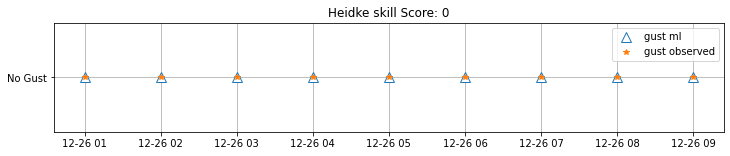

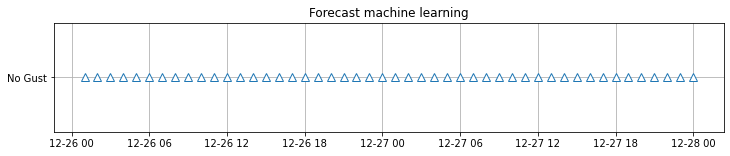

In [81]:
#@title Wind gust
#open algorithm gust d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/gust_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/gust_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat gust from ml
gust_ml = alg["pipe"].predict(model_x_var)
gust_ml1 = alg1["pipe"].predict(model_x_var1)

#label metars gust data
metars["gust_o_l"] = ["No Gust" if c=="M" else "Gust" for c in metars.gust_o]

#set up dataframe forecast machine learning 
df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "gust_ml": np.concatenate((gust_ml,gust_ml1),axis =0),})
df_for = df_for.set_index("time")

# concat metars an forecast
df_res = pd.concat([df_for,metars["gust_o_l"]], axis = 1)
df_res_dropna = df_res.dropna()

#Heidke skill score
cm = pd.crosstab(df_res.dropna().gust_o_l, df_res.dropna().gust_ml, margins=True,)
HSS = 0
if cm.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

#show results
print("***Wind direction***")
print("Reference (48 hours) Heidke skill Score: 0.42\n")
print("Confusion matrix")
print(cm)
#print(df_res)

plt.figure(figsize=(12, 2))
plt.plot(df_res_dropna.index, df_res_dropna['gust_ml'], marker="^", markersize=10, 
         markerfacecolor='w', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['gust_o_l'],marker="*",linestyle='');
plt.legend(('gust ml', 'gust observed'),)
plt.grid(True)
plt.title("Heidke skill Score: {}".format(HSS))
plt.show()


plt.figure(figsize=(12, 2))
plt.plot(df_for.index, df_for['gust_ml'],marker="^", markersize=8, markerfacecolor='w', linestyle='');
plt.title("Forecast machine learning")
plt.grid(True)
plt.show()

***Precipitation***
Reference (48 hours) Heidke skill score meteorological model: 0.43
Reference (48 hours) Heidke skill score machine learning: 0.55

Confusion matrix machine learning
prec_ml   No RA/DZ  All
prec_o_l               
No RA/DZ         8    8
RA/DZ            1    1
All              9    9

Confusion matrix meteorological model
prec_WRF  No RA/DZ  All
prec_o_l               
No RA/DZ         8    8
RA/DZ            1    1
All              9    9


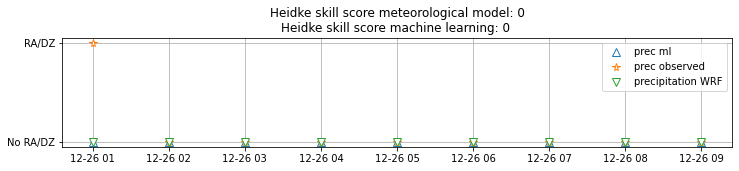

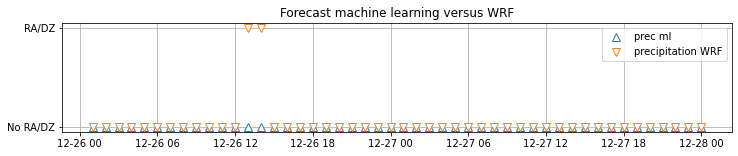

In [90]:
#@title Precipitation
#open algorithm prec d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/prec_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/prec_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat prec from ml
prec_ml = alg["pipe"].predict(model_x_var)
prec_ml1 = alg1["pipe"].predict(model_x_var1)

#label metars prec data
metars["prec_o_l"] = "No RA/DZ"
mask = metars['wxcodes_o'].str.contains("RA")
metars.loc[mask,["prec_o_l"]] = "RA/DZ"
mask = metars['wxcodes_o'].str.contains("DZ")
metars.loc[mask,["prec_o_l"]] = "RA/DZ"

#label meteorological model prec0
prec0_l= ["RA/DZ" if c>0 else "No RA/DZ" for c in np.concatenate((model_x_var["prec0"],model_x_var1["prec0"]), axis=0)]

#set up dataframe forecast machine learning 
df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "prec_WRF": prec0_l,
                       "prec_ml": np.concatenate((prec_ml,prec_ml1),axis =0),})
df_for = df_for.set_index("time")

# concat metars an forecast
df_res = pd.concat([df_for,metars["prec_o_l"]], axis = 1)
df_res_dropna = df_res.dropna()

#Heidke skill score ml
cm_ml = pd.crosstab(df_res.dropna().prec_o_l, df_res.dropna().prec_ml, margins=True,)
HSS_ml = 0
if cm_ml.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm_ml.values[0,0]
  b = cm_ml.values[1,0]
  c = cm_ml.values[0,1]
  d = cm_ml.values[1,1]
  HSS_ml = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

#Heidke skill score meteorological model
cm_wrf = pd.crosstab(df_res.dropna().prec_o_l, df_res.dropna().prec_WRF, margins=True,)
HSS_wrf = 0
if cm_wrf.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm_wrf.values[0,0]
  b = cm_wrf.values[1,0]
  c = cm_wrf.values[0,1]
  d = cm_wrf.values[1,1]
  HSS_wrf = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

#show results
print("***Precipitation***")
print("Reference (48 hours) Heidke skill score meteorological model: 0.43")
print("Reference (48 hours) Heidke skill score machine learning: 0.55\n")
print("Confusion matrix machine learning")
print(cm_ml)
print("\nConfusion matrix meteorological model")
print(cm_wrf)
#print(df_res)

plt.figure(figsize=(12, 2))
plt.plot(df_res_dropna.index, df_res_dropna['prec_ml'],marker="^", markersize=8, 
         markerfacecolor='w', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['prec_o_l'],marker="*",markersize=8, 
         markerfacecolor='w', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['prec_WRF'],marker="v",markersize=8, 
         markerfacecolor='w', linestyle='');
plt.legend(('prec ml', 'prec observed',"precipitation WRF"),)
plt.grid(True)
plt.title("Heidke skill score meteorological model: {}\nHeidke skill score machine learning: {} ".format(HSS_wrf,HSS_ml))
plt.show()


plt.figure(figsize=(12, 2))
plt.plot(df_for.index, df_for['prec_ml'],marker="^", markersize=8, markerfacecolor='w', linestyle='');
plt.plot(df_for.index, df_for['prec_WRF'],marker="v",markersize=8, markerfacecolor='w', linestyle='');
plt.legend(('prec ml', "precipitation WRF"),)
plt.title("Forecast machine learning versus WRF")
plt.grid(True)
plt.show()

***BR or FG***
Reference (48 hours) Heidke skill score machine learning: 0.64

Confusion matrix machine learning
brfg_ml   BR/FG  All
brfg_o_l            
BR/FG         9    9
All           9    9


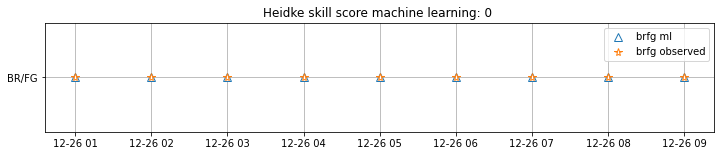

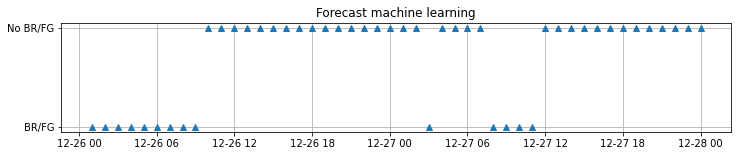

In [83]:
#@title BR or FG
#open algorithm prec d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/brfg_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/brfg_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat br/fg from ml
brfg_ml = alg["pipe"].predict(model_x_var)
brfg_ml1 = alg1["pipe"].predict(model_x_var1)

#label metars br/fg data
metars["brfg_o_l"] = "No BR/FG"
mask = metars['wxcodes_o'].str.contains("BR")
metars.loc[mask,["brfg_o_l"]] = "BR/FG"
mask = metars['wxcodes_o'].str.contains("FG")
metars.loc[mask,["brfg_o_l"]] = "BR/FG"



#set up dataframe forecast machine learning 
df_for = pd.DataFrame({"time": meteo_model[:48].index,
                       "brfg_ml": np.concatenate((brfg_ml,brfg_ml1),axis =0),})
df_for = df_for.set_index("time")

# concat metars an forecast
df_res = pd.concat([df_for,metars["brfg_o_l"]], axis = 1)
df_res_dropna = df_res.dropna()

#Heidke skill score ml
cm_ml = pd.crosstab(df_res.dropna().brfg_o_l, df_res.dropna().brfg_ml, margins=True,)
HSS_ml = 0
if cm_ml.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm_ml.values[0,0]
  b = cm_ml.values[1,0]
  c = cm_ml.values[0,1]
  d = cm_ml.values[1,1]
  HSS_ml = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)


#show results
print("***BR or FG***")
print("Reference (48 hours) Heidke skill score machine learning: 0.64\n")
print("Confusion matrix machine learning")
print(cm_ml)


plt.figure(figsize=(12, 2))
plt.plot(df_res_dropna.index, df_res_dropna['brfg_ml'],marker="^", markersize=8, 
         markerfacecolor='w', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['brfg_o_l'],marker="*",markersize=8, 
         markerfacecolor='w', linestyle='');
plt.legend(('brfg ml', 'brfg observed'),)
plt.grid(True)
plt.title("Heidke skill score machine learning: {} ".format(HSS_ml))
plt.show()


plt.figure(figsize=(12, 2))
plt.plot(df_for.index, df_for['brfg_ml'],marker="^",linestyle='');
plt.title("Forecast machine learning")
plt.grid(True)
plt.show()

***Visibility***
Reference (48 hours) Heidke skill score meteorological model: 0.25
Reference (48 hours) Heidke skill score machine learning: 0.52

Confusion matrix machine learning
vis_ml     > 1000 m  All
vis_o_l                 
<= 1000 m         7    7
> 1000 m          2    2
All               9    9

Confusion matrix meteorological model
vis_WRF    > 1000 m  All
vis_o_l                 
<= 1000 m         7    7
> 1000 m          2    2
All               9    9


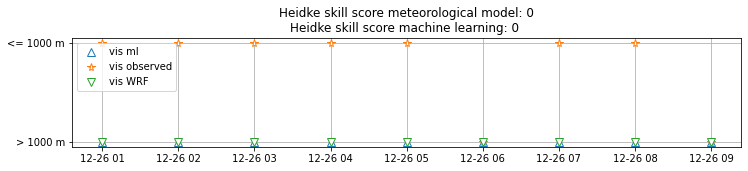

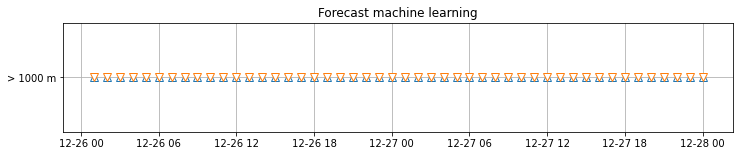

In [88]:
#@title visibility
#open algorithm visibility d0 d1

alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/vis_LEVX_1km_time_d0_p.al","rb")) #_p for a plus algorithm
#alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/vis_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/vis_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat vis from ml
vis_ml = alg["pipe"].predict(model_x_var)
vis_ml1 = alg1["pipe"].predict(model_x_var1)

#label metars vis data
metars["vis_o_l"] = ["<= 1000 m" if c<=1000 else "> 1000 m" for c in metars.visibility_o]

#label meteorological model visibility0
visibility0_l= ["<= 1000 m" if c<=1000 else "> 1000 m" for c in np.concatenate((model_x_var["visibility0"],model_x_var1["visibility0"]), axis=0)]

#set up dataframe forecast machine learning 
df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "vis_WRF": visibility0_l,
                       "vis_ml": np.concatenate((vis_ml,vis_ml1),axis =0),})
df_for = df_for.set_index("time")

# concat metars an forecast
df_res = pd.concat([df_for,metars["vis_o_l"]], axis = 1)
df_res_dropna = df_res.dropna()

#Heidke skill score ml
cm_ml = pd.crosstab(df_res.dropna().vis_o_l, df_res.dropna().vis_ml, margins=True,)
HSS_ml = 0
if cm_ml.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm_ml.values[0,0]
  b = cm_ml.values[1,0]
  c = cm_ml.values[0,1]
  d = cm_ml.values[1,1]
  HSS_ml = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

#Heidke skill score meteorological model
cm_wrf = pd.crosstab(df_res.dropna().vis_o_l, df_res.dropna().vis_WRF, margins=True,)
HSS_wrf = 0
if cm_wrf.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm_wrf.values[0,0]
  b = cm_wrf.values[1,0]
  c = cm_wrf.values[0,1]
  d = cm_wrf.values[1,1]
  HSS_wrf = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

#show results
print("***Visibility***")
print("Reference (48 hours) Heidke skill score meteorological model: 0.25")
print("Reference (48 hours) Heidke skill score machine learning: 0.52\n")
print("Confusion matrix machine learning")
print(cm_ml)
print("\nConfusion matrix meteorological model")
print(cm_wrf)
#print(df_res)

plt.figure(figsize=(12, 2))
plt.plot(df_res_dropna.index, df_res_dropna['vis_ml'],marker="^", markersize=8, 
         markerfacecolor='w', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['vis_o_l'],marker="*",markersize=8, 
         markerfacecolor='w', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['vis_WRF'],marker="v",markersize=8, 
         markerfacecolor='w', linestyle='');
plt.legend(('vis ml', 'vis observed',"vis WRF"),)
plt.grid(True)
plt.title("Heidke skill score meteorological model: {}\nHeidke skill score machine learning: {} ".format(HSS_wrf,HSS_ml))
plt.show()


plt.figure(figsize=(12, 2))
plt.plot(df_for.index, df_for['vis_ml'],marker="^", markersize=8, 
         markerfacecolor='w', linestyle='');
plt.plot(df_for.index, df_for['vis_WRF'],marker="v",markersize=8, 
         markerfacecolor='w', linestyle='');
plt.title("Forecast machine learning")
plt.grid(True)
plt.show()

***Temperature Celsius***
Reference (48 hours) Mean absolute error meteorological model: 1.44
Reference (48 hours) Mean absolute error machine learning: 0.85



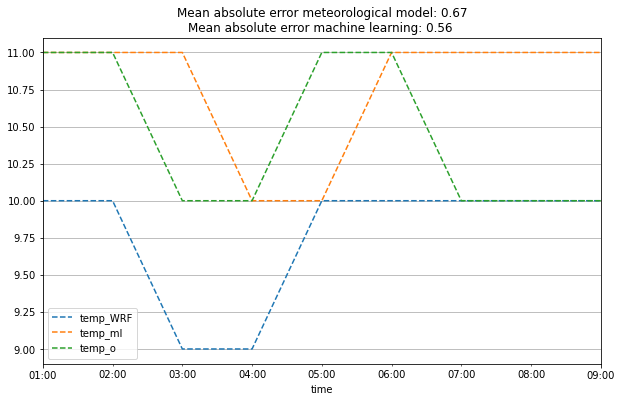

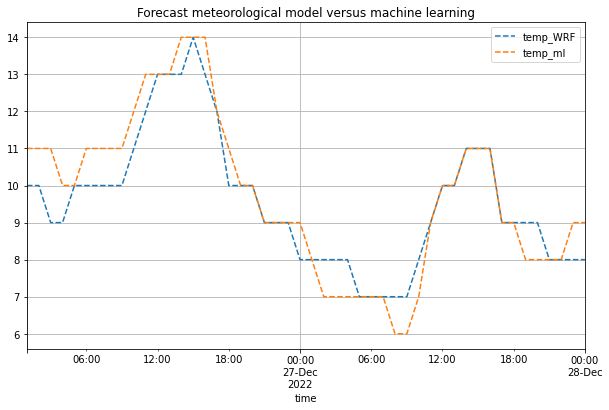

In [98]:
#@title Temperature
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#open algorithm temperature d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/temp_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/temp_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat temperature from ml
temp_ml = alg["pipe"].predict(meteo_model[:24][alg["x_var"]])
temp_ml1 = alg1["pipe"].predict(meteo_model[24:48][alg1["x_var"]])
df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "temp_WRF": np.concatenate((np.rint(model_x_var["temp0"]-273.16),
                                                   np.rint(model_x_var1["temp0"]-273.16)),axis=0),
                       "temp_ml": np.concatenate((np.rint(temp_ml-273.16),np.rint(temp_ml1-273.16)),axis =0),})
df_for = df_for.set_index("time")


# concat metars an forecast
df_res = pd.concat([df_for,metars["temp_o"]],axis = 1)

#get mae
df_res_dropna = df_res.dropna()
mae_ml = round(mean_absolute_error(df_res_dropna.temp_o,df_res_dropna.temp_ml),2)
mae_wrf = round(mean_absolute_error(df_res_dropna.temp_o,df_res_dropna.temp_WRF),2)

#print results
print("***Temperature Celsius***")
print("Reference (48 hours) Mean absolute error meteorological model: 1.44")
print("Reference (48 hours) Mean absolute error machine learning: 0.85\n")

#show results
title = "Mean absolute error meteorological model: {}\nMean absolute error machine learning: {} ".format(mae_wrf,mae_ml)
df_res.dropna().plot(grid=True,figsize=(10,6),linestyle='--',title = title);
df_for.plot(grid=True,figsize=(10,6),linestyle='--', title = "Forecast meteorological model versus machine learning");

***Dew Temperature Celsius***
Reference (48 hours) Mean absolute error machine learning: 0.95



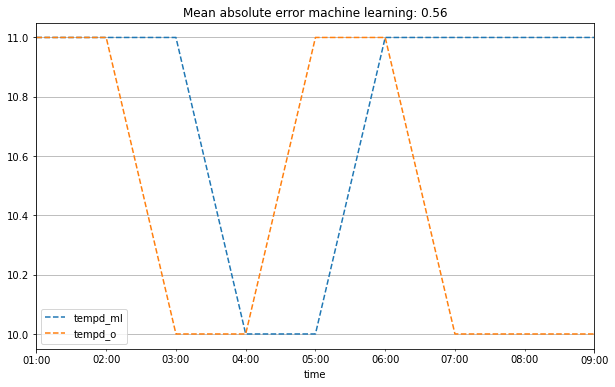

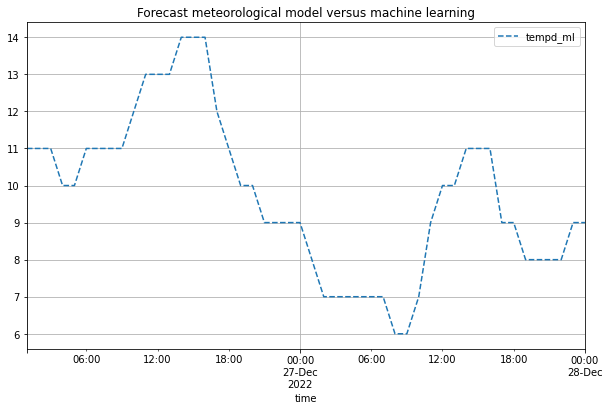

In [94]:
#@title Dew temperature
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#open algorithm tempd d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/tempd_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/tempd_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat spd from ml
tempd_ml = alg["pipe"].predict(meteo_model[:24][alg["x_var"]])
tempd_ml1 = alg1["pipe"].predict(meteo_model[24:48][alg1["x_var"]])

df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "tempd_ml": np.concatenate((np.rint(temp_ml-273.16),np.rint(temp_ml1-273.16)),axis =0),})
df_for = df_for.set_index("time")

# concat metars an forecast
df_res = pd.concat([df_for,metars["tempd_o"]],axis = 1)

#get mae
df_res_dropna = df_res.dropna()
mae_ml = round(mean_absolute_error(df_res_dropna.tempd_o,df_res_dropna.tempd_ml),2)

#print results
print("***Dew Temperature Celsius***")
print("Reference (48 hours) Mean absolute error machine learning: 0.95\n")

#show results
title = "Mean absolute error machine learning: {}".format(mae_ml)
df_res.dropna().plot(grid=True,figsize=(10,6),linestyle='--',title = title);
df_for.plot(grid=True,figsize=(10,6),linestyle='--', title = "Forecast meteorological model versus machine learning");

In [87]:
metars

,temp_o,tempd_o,mslp_o,visibility_o,spd_o,dir_o,gust_o,skyc1_o,skyl1_o,skyc2_o,skyl2_o,wxcodes_o,metar_o,dir_o_l,gust_o_l,prec_o_l,brfg_o_l,vis_o_l
time,,,,,,,,,,,,,,,,,,
2022-12-26 00:00:00,11.0,11.0,1020.0,644.0,5.0,190.00,M,SCT,100.0,BKN,200.00,FG,LEVX 260000Z 19005KT 150V220 0650 R19/P2000N R...,"(180, 200]",No Gust,No RA/DZ,BR/FG,<= 1000 m
2022-12-26 00:30:00,11.0,11.0,1020.0,6003.0,4.0,190.00,M,SCT,100.0,BKN,200.00,BCFG,LEVX 260030Z 19004KT 150V220 6000 BCFG SCT001 ...,"(180, 200]",No Gust,No RA/DZ,BR/FG,> 1000 m
2022-12-26 01:00:00,11.0,11.0,1021.0,901.0,5.0,190.00,M,SCT,0.0,BKN,200.00,BCFG DZ,LEVX 260100Z 19005KT 160V220 0900 R19/1900N R0...,"(180, 200]",No Gust,RA/DZ,BR/FG,<= 1000 m
2022-12-26 01:30:00,11.0,11.0,1021.0,145.0,2.0,M,M,BKN,0.0,BKN,200.00,FG DZ,LEVX 260130Z VRB02KT 0150 R19/0400D R01/0150N ...,VRB,No Gust,RA/DZ,BR/FG,<= 1000 m
2022-12-26 02:00:00,11.0,11.0,1021.0,193.0,2.0,M,M,FEW,0.0,BKN,100.00,FG,LEVX 260200Z VRB02KT 0200 R19/0300D R01/0200N ...,VRB,No Gust,No RA/DZ,BR/FG,<= 1000 m
2022-12-26 02:30:00,10.0,10.0,1021.0,145.0,0.0,0.00,M,FEW,0.0,BKN,100.00,FG,LEVX 260230Z 00000KT 0150 R19/0175N R01/0225D ...,"[0, 20]",No Gust,No RA/DZ,BR/FG,<= 1000 m
2022-12-26 03:00:00,10.0,10.0,1022.0,354.0,3.0,240.00,M,FEW,100.0,SCT,1400.00,BCFG,LEVX 260300Z 24003KT 200V270 0350 R19/0650D R0...,"(220, 240]",No Gust,No RA/DZ,BR/FG,<= 1000 m
2022-12-26 03:30:00,10.0,10.0,1022.0,306.0,2.0,M,M,SCT,100.0,BKN,2500.00,BCFG,LEVX 260330Z VRB02KT 0300 R19/0325N R01/0325N ...,VRB,No Gust,No RA/DZ,BR/FG,<= 1000 m
2022-12-26 04:00:00,10.0,10.0,1022.0,354.0,2.0,M,M,BKN,100.0,BKN,200.00,BCFG,LEVX 260400Z VRB02KT 0350 R19/1000U R01/0900N ...,VRB,No Gust,No RA/DZ,BR/FG,<= 1000 m
